In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
%matplotlib inline

In [49]:
def noiseReductionUsingGaussian(image, Kx = 5, Ky = 5) :
    """
    Performs Gaussian Blurring
    
    Parameters
    ----------
    image : (M,N) ndarray
        Input image
    Kx : Int
        Kernel size in X direction
    Ky : Int
        Kernel size in Y direction
   
    Returns
    -------
    image : (M, N) ndarray
        Image after smoothing.
    """
    blur = cv2.GaussianBlur(image,(Kx,Ky),0)
    return blur

(184, 274)


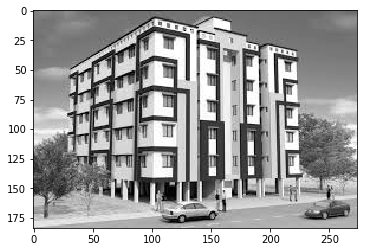

In [50]:
image = cv2.imread("/home/guru/Desktop/ComputerVision/Assignment1/IpythonNotebooks/images.jpeg",0)
print(image.shape)
plt.imshow(image,cmap = "gray")

In [51]:
image

array([[124, 125, 127, ..., 104, 104, 104],
       [124, 125, 127, ..., 107, 107, 107],
       [124, 125, 126, ..., 112, 113, 113],
       ..., 
       [225, 226, 226, ..., 177, 177, 177],
       [219, 220, 223, ..., 177, 177, 177],
       [200, 198, 194, ..., 178, 178, 178]], dtype=uint8)

In [52]:
#Noise Removal Step
blur = noiseReductionUsingGaussian(image,3,3)

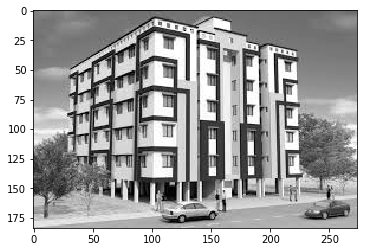

In [53]:
plt.imshow(image,cmap = "gray")

In [54]:
def round_angle(angle) :
    """
    Converts angle in radians to degrees and rounds off to nearest direction angle
    
    Parameters 
    ----------
    angle : Radians
        Angle to be converted
    
    Returns
    --------
    angle : Degrees
        One of the direction angle
    
    """
    #Converting angle from radians to degrees
    angle = np.rad2deg(angle) % 180
   # print(angle)
    
    #Rounding to horizontal direction
    if (0 <= angle < 22.5) or (157.5 <= angle < 180):
        angle = 0
        
    #Rounding to diagonal direction
    elif(22.5 <= angle < 67.5):
        angle = 45
        
    #Rounding to vertical direction
    elif(67.5 <= angle < 112.5):
        angle = 90
    
    #Rounding to diagonal direction
    else :
        angle = 135
        
    return angle

In [57]:
def intensity_gradient(image, Kx = 3, Ky = 3) :
    """
    Calculates the gradient and its direction for entire image using Sobel Operator
    
    Parameters
    ----------
    image : (M,N) ndarray
        Input image
    Kx : Int
        Kernel size in X direction
    Ky : Int
        Kernel size in Y direction
    
    Returns
    -------
    (Gradient, Direction, Ix, Iy) : Tuple
    
    """
    #Finding Gradient using sobel operator  
    #Applying Kernels to the image
    Ix = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=Kx)
    Iy = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=Ky)
    

    #Calculating the gradient magnitude and direction
    G = np.hypot(Ix, Iy)
    D = np.arctan2(Iy, Ix);
    
    #Calculating the Directions by rounding off
    M, N = D.shape
    R_D = np.zeros((M,N), dtype = np.int32)
    
    #print(D.shape)
    #print(D[0][0])
    for i in range(M) :
        for j in range(N) :
            R_D[i][j] = round_angle(D[i,j])
    
    return (G,R_D,Ix,Iy)

In [58]:
gradient, direction,Ix,Iy = intensity_gradient(blur)

In [59]:
np.min(Ix)

-712.0

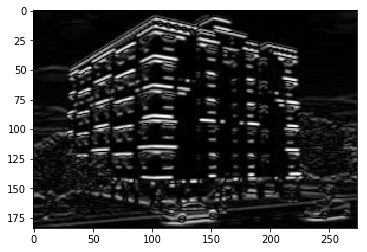

In [60]:
plt.imshow(np.abs(Iy),cmap = "gray")

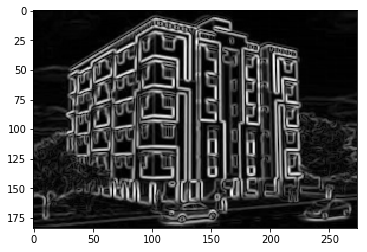

In [61]:
plt.imshow(gradient,cmap = "gray")

In [62]:
direction

array([[ 0,  0,  0, ...,  0,  0,  0],
       [90,  0,  0, ..., 90, 90, 90],
       [90,  0,  0, ..., 90, 90, 90],
       ..., 
       [90, 90, 90, ...,  0,  0,  0],
       [90, 90, 90, ..., 90, 90, 90],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int32)

In [18]:
def non_max_supression(gradient, direction) :
    """
    
    """
    M, N = gradient.shape
    S = np.zeros((M,N), dtype = np.int32)
    #Todo : Dealing in a better way with boundary points
    for i in range(M):
        for j in range(N):
            if(direction[i][j] == 0) :
                if((j!= 0 and j!= N-1) and (gradient[i, j] >= gradient[i, j - 1]) and (gradient[i, j] >= gradient[i, j + 1])):
                    S[i,j] = gradient[i,j]
                    
            elif(direction[i][j] == 90) :
                if ((i!=0 and i!= M-1) and (gradient[i, j] >= gradient[i - 1, j]) and (gradient[i, j] >= gradient[i + 1, j])):
                    S[i,j] = gradient[i,j]
            
            elif(direction[i][j] == 45) :
                if ((i!=0 and i!=M-1 and j!=0 and j!= N-1 ) and (gradient[i, j] >= gradient[i - 1, j + 1]) and (gradient[i, j] >= gradient[i + 1, j - 1])):
                    S[i,j] = gradient[i,j]
            
            elif(direction[i][j] == 135) :
                if ((i!=0 and i!=M-1 and j!=0 and j!= N-1 ) and gradient[i, j] >= gradient[i - 1, j - 1]) and (gradient[i, j] >= gradient[i + 1, j + 1]):
                    S[i,j] = gradient[i,j]
    
    return S
    

In [19]:
S = non_max_supression(gradient, direction)

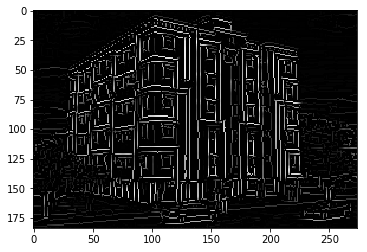

In [20]:
plt.imshow(S, cmap = "gray")

In [21]:
S

array([[ 0,  0, 16, ...,  0,  2,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ..., 
       [44,  0,  0, ...,  0,  0,  0],
       [ 0, 44, 48, ...,  0,  0,  0],
       [ 0,  0,  2, ...,  0,  0,  0]], dtype=int32)

In [22]:
def h_threshold(image, low, high) :
    low = np.clip(low, a_min=None, a_max=high)  # ensure low always below high
    mask_low = image > low
    mask_high = image > high
    print(mask_high*1)
    # Connected components of mask_low
    labels_low, num_labels = ndimage.label(mask_low)

    # Check which connected components contain pixels from mask_high
    sums = ndimage.sum(mask_high, labels_low, np.arange(num_labels + 1))
    connected_to_high = sums > 0
    thresholded = connected_to_high[labels_low]
    return thresholded


In [23]:
S

array([[ 0,  0, 16, ...,  0,  2,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ..., 
       [44,  0,  0, ...,  0,  0,  0],
       [ 0, 44, 48, ...,  0,  0,  0],
       [ 0,  0,  2, ...,  0,  0,  0]], dtype=int32)

In [33]:
blah = h_threshold(S,50,150)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [34]:
blah.dtype

dtype('bool')

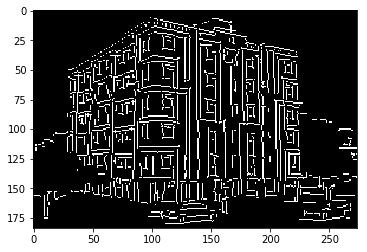

In [35]:
plt.imshow(blah, cmap = "gray")

In [44]:
def hsvColor(edgeImage, gradient, direction) :
    M,N = edgeImage.shape
    hsv_image = np.zeros((M,N,3), dtype = np.uint8)
    
    max_gradient = np.max(gradient)
    min_gradient = np.min(gradient)
    for i in range(M) :
        for j in range (N) :
            if(edgeImage[i][j]) :
                v = int(255*((gradient[i][j] - min_gradient)/(max_gradient - min_gradient)))
                if(direction[i][j] == 0) :
                    hsv_image[i][j] = [0,255,v]
                elif(direction[i][j] == 45) :
                     hsv_image[i][j] = [45,255,v]
                elif(direction[i][j] == 90) :
                     hsv_image[i][j] = [90,255,v]
                else :
                     hsv_image[i][j] = [135,255,v]
                        
    return cv2.cvtColor(hsv_image,cv2.COLOR_HSV2RGB)

In [45]:
hsv_image = hsvColor(blah, gradient, direction)

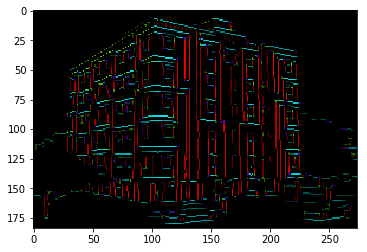

In [46]:
plt.imshow(hsv_image)

In [24]:
def hysteresisThresholding(gradient, minVal,maxVal) :
    sure_edge_i, sure_edge_j = np.where(gradient > maxVal)
    doubt_i, doubt_j = np.where((gradient >= minVal) & (gradient <= maxVal))
    non_edge_i, non_edge_j = np.where(gradient < minVal)
    
    gradient[sure_edge_i, sure_edge_j] = np.int(255)
    gradient[doubt_i, doubt_j] = np.int(128)
    gradient[non_edge_i, non_edge_j] = np.int(0)
    
    
    M,N = gradient.shape
    
    for i in range(1,M-1) :
        for j in range(1,N-1) :
            if(gradient[i][j] == 128) :
                if ((gradient[i + 1, j] == 255) or (gradient[i - 1, j] == 128)
                         or (gradient[i, j + 1] == 255) or (gradient[i, j - 1] == 255)
                         or (gradient[i+1, j + 1] == 255) or (gradient[i-1, j - 1] == 255)):
                    gradient[i][j] = np.int(255)
                else :
                    gradient[i][j] = np.int(0)
    return gradient.astype(int)